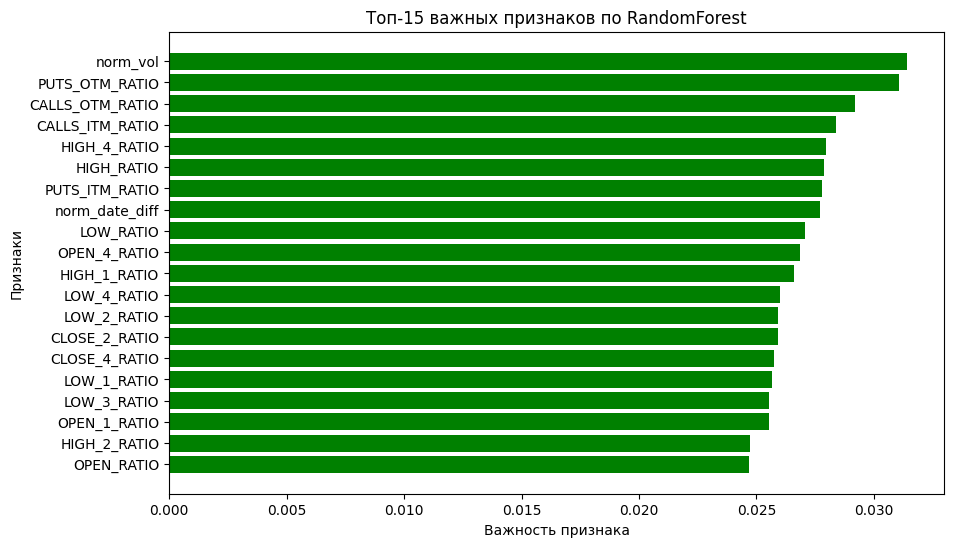

In [267]:
import pandas as pd
import numpy as np
import random
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

# Загрузка данных
df = pd.read_csv(r"../features.csv")

# # Уменьшение разрядности числовых данных
# for col in df.select_dtypes(include=["float64"]).columns:
#     df[col] = df[col].astype("float32")

# Уменьшаем размер выборки (например, 10% данных)
# df_sampled = df.sample(frac=0.1, random_state=42)

df_sampled = df

# Разделение на X (признаки) и y (целевая переменная)
X = df_sampled.drop(columns=["target"])  # Укажи правильное название столбца с классами
y = df_sampled["target"]

# Выбираем случайные 50 признаков
random.seed(42)
selected_columns = random.sample(list(X.columns), min(50, X.shape[1]))
X_selected = X[selected_columns]

# Разделение на train/test
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

# Обучение RandomForestClassifier для оценки важности признаков
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Получение важности признаков
feature_importances = rf_model.feature_importances_

# Визуализация топ-15 признаков
sorted_idx = np.argsort(feature_importances)[::-1][:20]

plt.figure(figsize=(10, 6))
plt.barh(np.array(selected_columns)[sorted_idx], feature_importances[sorted_idx], color="green")
plt.xlabel("Важность признака")
plt.ylabel("Признаки")
plt.title("Топ-15 важных признаков по RandomForest")
plt.gca().invert_yaxis()
plt.show()


In [268]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

# Обучение модели XGBoost
xgb_model = XGBClassifier(n_estimators=100, max_depth=5, learning_rate=0.1, random_state=42)
# xgb_model = XGBClassifier(n_estimators=200, max_depth=6, learning_rate=0.05, random_state=42)
xgb_model.fit(X_train, y_train)

# Предсказание
y_pred = xgb_model.predict(X_test)

# Оценка точности
accuracy = accuracy_score(y_test, y_pred)
print(f"Точность XGBoost: {accuracy:.4f}")


Точность XGBoost: 0.4705


In [269]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import accuracy_score
import numpy as np

# 📌 Отбор 10 лучших признаков
selector = SelectKBest(score_func=f_classif, k=10)
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)

# 🔥 Стандартизация данных
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_selected)
X_test_scaled = scaler.transform(X_test_selected)

# 📌 Преобразуем данные в тензоры
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

# 📌 Создаем датасеты и DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# 📌 Подсчет весов классов (балансировка)
class_counts = np.bincount(y_train)
class_weights = torch.tensor([class_counts[1] / class_counts[0]], dtype=torch.float32)
print(f"Используемый вес для класса 1: {class_weights.item():.4f}")

# 📌 Улучшенная архитектура нейросети
class SimpleNeuralNet(nn.Module):
    def __init__(self, input_size):
        super(SimpleNeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, 256)
        self.bn1 = nn.BatchNorm1d(256)
        self.fc2 = nn.Linear(256, 128)
        self.bn2 = nn.BatchNorm1d(128)
        self.fc3 = nn.Linear(128, 1)
        self.swish = nn.SiLU()
        self.dropout = nn.Dropout(0.3)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # x = self.swish(self.bn1(self.fc1(x)))
        x = self.swish(self.fc1(x))
        x = self.dropout(x)
        # x = self.swish(self.bn2(self.fc2(x)))
        x = self.swish(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

# 📌 Инициализация модели
model = SimpleNeuralNet(X_train_selected.shape[1])

# 📌 Функция ошибки (BCELoss с балансировкой классов)
criterion = nn.BCEWithLogitsLoss(pos_weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

# 📌 Обучение модели с ранней остановкой
epochs = 1000
best_acc = 0
patience = 200
counter = 0
best_model_path = "best_model.pth"

for epoch in range(epochs):
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        y_pred = model(batch_X)
        loss = criterion(y_pred, batch_y)
        loss.backward()
        optimizer.step()
    
    # 📌 Оценка точности
    with torch.no_grad():
        y_pred_test = (torch.sigmoid(model(X_test_tensor)) > 0.5).float()
        accuracy = (y_pred_test.eq(y_test_tensor).sum() / y_test_tensor.shape[0]).item()
    
    print(f"Эпоха {epoch+1}/{epochs}, Потери: {loss.item():.4f}, Точность: {accuracy:.4f}")

    # 📌 Сохранение лучшей модели
    if accuracy > best_acc:
        best_acc = accuracy
        counter = 0
        torch.save(model.state_dict(), best_model_path)
    else:
        counter += 1
    
    if counter >= patience:
        print(f"⏹️ Остановка на {epoch+1} эпохе (без улучшений {patience} эпох подряд).")
        break

print(f"🚀 Итоговая точность обученной модели: {best_acc:.4f}")

# 📌 ЗАГРУЗКА ЛУЧШЕЙ МОДЕЛИ И ПРОВЕРКА НА ТЕСТОВЫХ ДАННЫХ
print("\n📌 Загружаем лучшую модель и тестируем на тестовых данных...")
model.load_state_dict(torch.load(best_model_path))
model.eval()

# 📌 Проверка на тестовой выборке
with torch.no_grad():
    y_pred_final = (torch.sigmoid(model(X_test_tensor)) > 0.5).float()
    final_accuracy = (y_pred_final.eq(y_test_tensor).sum() / y_test_tensor.shape[0]).item()

print(f"✅ Итоговая точность загруженной модели: {final_accuracy:.4f}")


Используемый вес для класса 1: 1.1212
Эпоха 1/1000, Потери: 0.7315, Точность: 0.5098
Эпоха 2/1000, Потери: 0.7348, Точность: 0.5059
Эпоха 3/1000, Потери: 0.7187, Точность: 0.4980
Эпоха 4/1000, Потери: 0.7423, Точность: 0.5059
Эпоха 5/1000, Потери: 0.7271, Точность: 0.5059
Эпоха 6/1000, Потери: 0.7354, Точность: 0.5039
Эпоха 7/1000, Потери: 0.7260, Точность: 0.5118
Эпоха 8/1000, Потери: 0.7272, Точность: 0.5157
Эпоха 9/1000, Потери: 0.7618, Точность: 0.5138
Эпоха 10/1000, Потери: 0.7364, Точность: 0.5118
Эпоха 11/1000, Потери: 0.7615, Точность: 0.5098
Эпоха 12/1000, Потери: 0.7149, Точность: 0.5059
Эпоха 13/1000, Потери: 0.7373, Точность: 0.5059
Эпоха 14/1000, Потери: 0.7443, Точность: 0.5079
Эпоха 15/1000, Потери: 0.7404, Точность: 0.5059
Эпоха 16/1000, Потери: 0.7502, Точность: 0.5020
Эпоха 17/1000, Потери: 0.7441, Точность: 0.5059
Эпоха 18/1000, Потери: 0.7396, Точность: 0.5098
Эпоха 19/1000, Потери: 0.7410, Точность: 0.5138
Эпоха 20/1000, Потери: 0.7443, Точность: 0.5079
Эпоха 21/10

In [270]:
# import torch
# import torch.nn as nn
# import torch.optim as optim
# from torch.utils.data import TensorDataset, DataLoader
# from sklearn.preprocessing import StandardScaler
# from sklearn.feature_selection import SelectKBest, f_classif
# from sklearn.metrics import accuracy_score
# import numpy as np

# # 📌 Отбор 10 лучших признаков
# selector = SelectKBest(score_func=f_classif, k=10)
# X_train_selected = selector.fit_transform(X_train, y_train)
# X_test_selected = selector.transform(X_test)

# # 🔥 Стандартизация данных
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train_selected)
# X_test_scaled = scaler.transform(X_test_selected)

# # 📌 Преобразуем данные в тензоры
# X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
# y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
# X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
# y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

# # 📌 Создаем датасеты и DataLoader
# train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
# train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# # 📌 Подсчет весов классов (балансировка)
# class_counts = np.bincount(y_train)
# class_weights = torch.tensor([class_counts[1] / class_counts[0]], dtype=torch.float32)  # Вес для класса 1
# print(f"Используемый вес для класса 1: {class_weights.item():.4f}")

# # 📌 Улучшенная архитектура нейросети
# class SimpleNeuralNet(nn.Module):
#     def __init__(self, input_size):
#         super(SimpleNeuralNet, self).__init__()
#         self.fc1 = nn.Linear(input_size, 256)
#         self.fc2 = nn.Linear(256, 128)
#         self.fc3 = nn.Linear(128, 1)
#         self.swish = nn.SiLU()
#         self.dropout = nn.Dropout(0.3)  # Dropout 30%
#         self.sigmoid = nn.Sigmoid()

#     def forward(self, x):
#         x = self.swish(self.fc1(x))
#         # x = self.dropout(x)
#         x = self.swish(self.fc2(x))
#         # x = self.dropout(x)
#         x = self.fc3(x)  # Логиты (без сигмоиды)
#         return x

# # 📌 Инициализация модели
# model = SimpleNeuralNet(X_train_selected.shape[1])

# # 📌 Функция ошибки (BCELoss с балансировкой классов)
# criterion = nn.BCEWithLogitsLoss(pos_weight=class_weights)
# optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
# # optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)

# # 📌 Обучение модели с ранней остановкой
# epochs = 1000
# best_acc = 0
# patience = 200  # Остановимся, если 50 эпох нет улучшений
# counter = 0
# best_model_path = "best_model.pth"  # Файл для сохранения модели

# for epoch in range(epochs):
#     for batch_X, batch_y in train_loader:
#         optimizer.zero_grad()
#         y_pred = model(batch_X)
#         loss = criterion(y_pred, batch_y)
#         loss.backward()
#         optimizer.step()
    
#     # 📌 Оценка точности
#     with torch.no_grad():
#         y_pred_test = (torch.sigmoid(model(X_test_tensor)) > 0.5).float()
#         accuracy = (y_pred_test.eq(y_test_tensor).sum() / y_test_tensor.shape[0]).item()
    
#     print(f"Эпоха {epoch+1}/{epochs}, Потери: {loss.item():.4f}, Точность: {accuracy:.4f}")

#     # 📌 Сохранение лучшей модели
#     if accuracy > best_acc:
#         best_acc = accuracy
#         counter = 0  # Сбрасываем счётчик
#         torch.save(model.state_dict(), best_model_path)  # 💾 Сохранение модели
#     else:
#         counter += 1
    
#     if counter >= patience:
#         print(f"⏹️ Остановка на {epoch+1} эпохе (без улучшений {patience} эпох подряд).")
#         break

# print(f"🚀 Итоговая точность обученной модели: {best_acc:.4f}")

# # 📌 ЗАГРУЗКА ЛУЧШЕЙ МОДЕЛИ И ПРОВЕРКА НА ТЕСТОВЫХ ДАННЫХ
# print("\n📌 Загружаем лучшую модель и тестируем на тестовых данных...")
# model.load_state_dict(torch.load(best_model_path))  # 🔄 Загрузка модели
# model.eval()  # Переключение в режим оценки

# # 📌 Проверка на тестовой выборке
# with torch.no_grad():
#     y_pred_final = (torch.sigmoid(model(X_test_tensor)) > 0.5).float()
#     final_accuracy = (y_pred_final.eq(y_test_tensor).sum() / y_test_tensor.shape[0]).item()

# print(f"✅ Итоговая точность загруженной модели: {final_accuracy:.4f}")




In [271]:
# import torch
# import torch.nn as nn
# import torch.optim as optim
# from torch.utils.data import TensorDataset, DataLoader
# from sklearn.preprocessing import StandardScaler
# from sklearn.feature_selection import SelectKBest, f_classif
# from sklearn.metrics import accuracy_score
# import numpy as np

# # 📌 Отбор 10 лучших признаков
# selector = SelectKBest(score_func=f_classif, k=10)
# X_train_selected = selector.fit_transform(X_train, y_train)
# X_test_selected = selector.transform(X_test)

# # 🔥 Стандартизация данных
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train_selected)
# X_test_scaled = scaler.transform(X_test_selected)

# # 📌 Преобразуем данные в тензоры
# X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
# y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
# X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
# y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

# # 📌 Создаем датасеты и DataLoader
# train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
# train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# # 📌 Подсчет весов классов (балансировка)
# class_counts = np.bincount(y_train)
# class_weights = torch.tensor([class_counts[1] / class_counts[0]], dtype=torch.float32)
# print(f"Используемый вес для класса 1: {class_weights.item():.4f}")

# # 📌 Улучшенная архитектура нейросети с BatchNorm
# class SimpleNeuralNet(nn.Module):
#     def __init__(self, input_size):
#         super(SimpleNeuralNet, self).__init__()
#         self.fc1 = nn.Linear(input_size, 256)
#         self.bn1 = nn.BatchNorm1d(256)
#         self.fc2 = nn.Linear(256, 128)
#         self.bn2 = nn.BatchNorm1d(128)
#         self.fc3 = nn.Linear(128, 1)
#         self.swish = nn.SiLU()
#         self.dropout = nn.Dropout(0.3)  # Увеличенный Dropout

#     def forward(self, x):
#         x = self.swish(self.bn1(self.fc1(x)))
#         # x = self.dropout(x)
#         x = self.swish(self.bn2(self.fc2(x)))
#         # x = self.dropout(x)
#         x = self.fc3(x)  # Логиты (без сигмоиды)
#         return x

# # 📌 Инициализация модели
# model = SimpleNeuralNet(X_train_selected.shape[1])

# # 📌 Функция ошибки (BCELoss с балансировкой классов)
# criterion = nn.BCEWithLogitsLoss(pos_weight=class_weights)
# optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

# # 📌 Обучение модели с ранней остановкой
# epochs = 1000
# best_acc = 0
# patience = 200
# counter = 0
# best_model_path = "best_model.pth"

# for epoch in range(epochs):
#     for batch_X, batch_y in train_loader:
#         optimizer.zero_grad()
#         y_pred = model(batch_X)
#         loss = criterion(y_pred, batch_y)
#         loss.backward()
#         optimizer.step()
    
#     # 📌 Оценка точности
#     with torch.no_grad():
#         y_pred_test = (torch.sigmoid(model(X_test_tensor)) > 0.5).float()
#         accuracy = (y_pred_test.eq(y_test_tensor).sum() / y_test_tensor.shape[0]).item()
    
#     print(f"Эпоха {epoch+1}/{epochs}, Потери: {loss.item():.4f}, Точность: {accuracy:.4f}")

#     # 📌 Сохранение лучшей модели
#     if accuracy > best_acc:
#         best_acc = accuracy
#         counter = 0
#         torch.save(model.state_dict(), best_model_path)
#     else:
#         counter += 1
    
#     if counter >= patience:
#         print(f"⏹️ Остановка на {epoch+1} эпохе (без улучшений {patience} эпох подряд).")
#         break

# print(f"🚀 Итоговая точность обученной модели: {best_acc:.4f}")

# # 📌 ЗАГРУЗКА ЛУЧШЕЙ МОДЕЛИ И ПРОВЕРКА НА ТЕСТОВЫХ ДАННЫХ
# print("\n📌 Загружаем лучшую модель и тестируем на тестовых данных...")
# model.load_state_dict(torch.load(best_model_path))
# model.eval()

# # 📌 Проверка на тестовой выборке
# with torch.no_grad():
#     y_pred_final = (torch.sigmoid(model(X_test_tensor)) > 0.5).float()
#     final_accuracy = (y_pred_final.eq(y_test_tensor).sum() / y_test_tensor.shape[0]).item()

# print(f"✅ Итоговая точность загруженной модели: {final_accuracy:.4f}")
